2025-08-02 09:46:05,919 - INFO - 🎯 TD Learning Implementation - Complete with Logging
2025-08-02 09:46:05,920 - INFO - Environment: 5 states (0 to 4)
2025-08-02 09:46:05,920 - INFO - Goal: Reach terminal state 4 for reward +10
2025-08-02 09:46:05,920 - INFO - 
🚀 Starting TD Learning Training for 100 episodes
2025-08-02 09:46:05,920 - INFO - Parameters - Alpha: 0.1, Gamma: 0.9
2025-08-02 09:46:05,920 - INFO - 
=== Starting New Episode ===
2025-08-02 09:46:05,920 - INFO - TD Update - State: 0, Reward: -1, Target: -1.000, TD Error: -1.000, New V(s): -0.100
2025-08-02 09:46:05,921 - INFO - TD Update - State: 0, Reward: 0, Target: 0.000, TD Error: 0.100, New V(s): -0.090
2025-08-02 09:46:05,921 - INFO - TD Update - State: 1, Reward: 0, Target: 0.000, TD Error: 0.000, New V(s): 0.000
2025-08-02 09:46:05,921 - INFO - TD Update - State: 2, Reward: -1, Target: -1.000, TD Error: -1.000, New V(s): -0.100
2025-08-02 09:46:05,921 - INFO - TD Update - State: 2, Reward: 0, Target: 0.000, TD Error: 0.

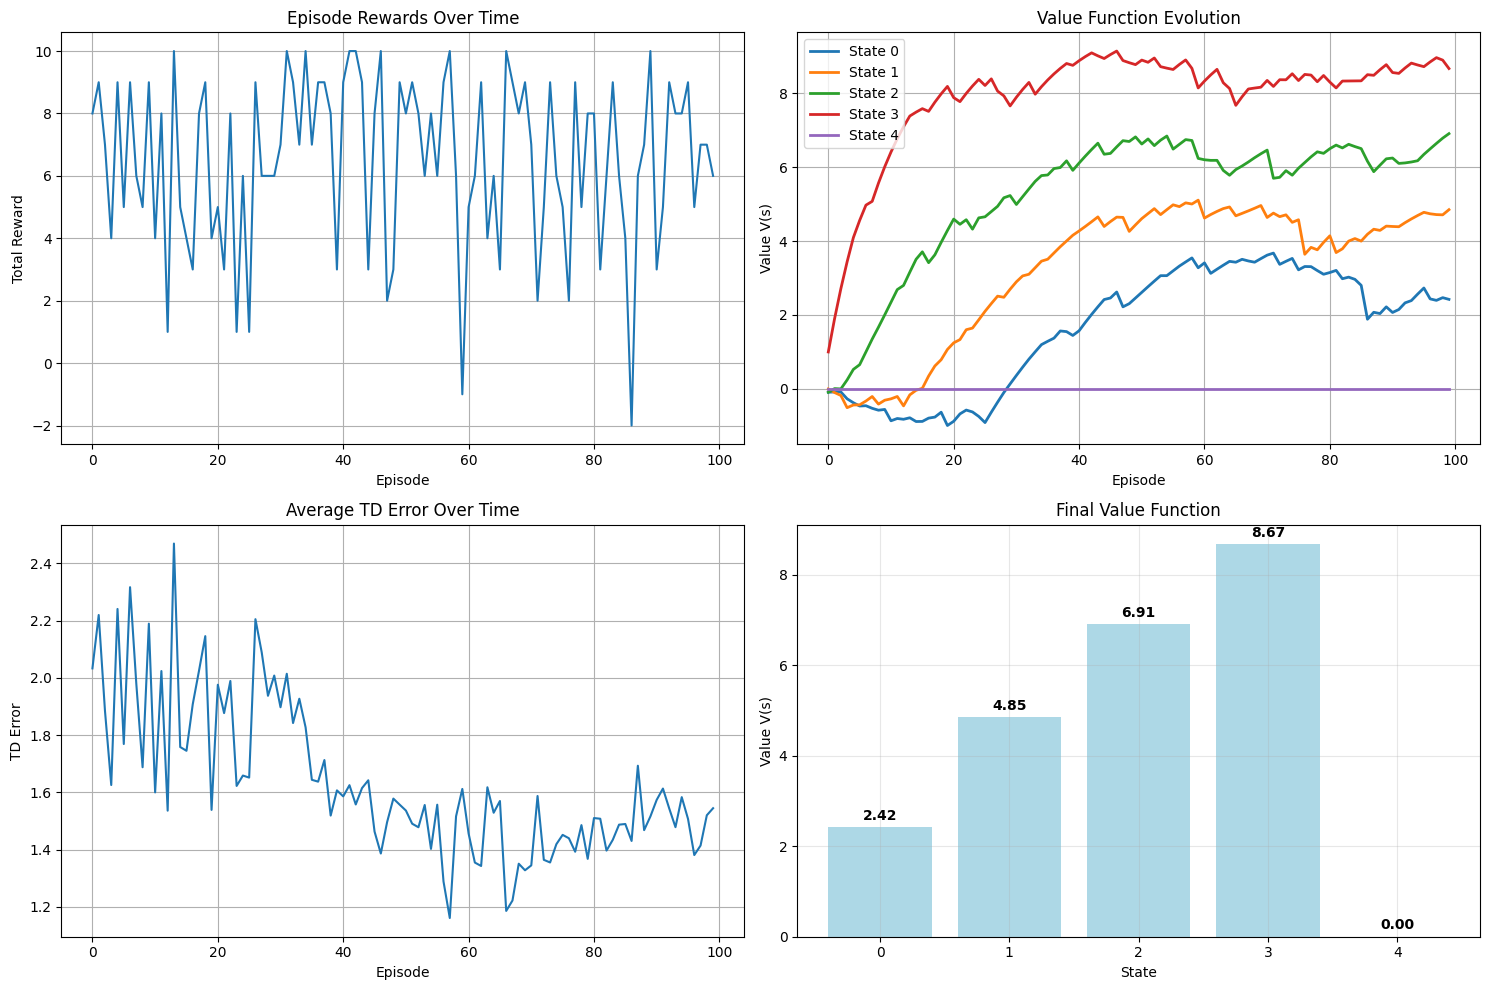

2025-08-02 09:46:06,655 - INFO - 
🎉 Experiment Complete!
2025-08-02 09:46:06,655 - INFO - 📁 Files saved: td_learning_20250802_094606.json, td_learning_plots_20250802_094606.png


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import logging
from collections import defaultdict
import json
import os
from datetime import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class TDLearningEnvironment:
    def __init__(self, num_states=5):
        self.num_states = num_states
        self.current_state = 0
        self.terminal_state = num_states - 1
        self.reset()
        
    def reset(self):
        self.current_state = 0
        return self.current_state
    
    def step(self, action):
        if self.current_state == self.terminal_state:
            return self.current_state, 0, True
        
        reward = 0
        if action == 1:
            self.current_state += 1
            if self.current_state == self.terminal_state:
                reward = 10
        else:
            reward = -1
            
        done = self.current_state == self.terminal_state
        return self.current_state, reward, done

class TDLearningAgent:
    def __init__(self, num_states, alpha=0.1, gamma=0.9):
        self.num_states = num_states
        self.alpha = alpha
        self.gamma = gamma
        self.V = np.zeros(num_states)
        self.episode_rewards = []
        self.value_history = []
        self.td_errors = []
        self.training_metrics = {
            'episodes': [],
            'total_rewards': [],
            'avg_td_error': [],
            'convergence_rate': []
        }
        
    def get_action(self, state):
        return random.choice([0, 1])
    
    def td_update(self, state, reward, next_state, done):
        if done:
            target = reward
        else:
            target = reward + self.gamma * self.V[next_state]
        
        td_error = target - self.V[state]
        self.V[state] += self.alpha * td_error
        
        self.td_errors.append(abs(td_error))
        
        logger.info(f"TD Update - State: {state}, Reward: {reward}, Target: {target:.3f}, "
                   f"TD Error: {td_error:.3f}, New V(s): {self.V[state]:.3f}")
        
        return td_error
    
    def train_episode(self, env):
        state = env.reset()
        total_reward = 0
        episode_td_errors = []
        episode_states = []
        
        logger.info(f"\n=== Starting New Episode ===")
        
        while True:
            action = self.get_action(state)
            next_state, reward, done = env.step(action)
            
            td_error = self.td_update(state, reward, next_state, done)
            episode_td_errors.append(abs(td_error))
            episode_states.append(state)
            
            total_reward += reward
            
            if done:
                break
                
            state = next_state
        
        self.episode_rewards.append(total_reward)
        self.value_history.append(self.V.copy())
        
        avg_td_error = np.mean(episode_td_errors) if episode_td_errors else 0
        logger.info(f"Episode Complete - Total Reward: {total_reward}, "
                   f"Avg TD Error: {avg_td_error:.3f}")
        
        return total_reward, avg_td_error, episode_states
    
    def train(self, env, num_episodes=100):
        logger.info(f"\n🚀 Starting TD Learning Training for {num_episodes} episodes")
        logger.info(f"Parameters - Alpha: {self.alpha}, Gamma: {self.gamma}")
        
        for episode in range(num_episodes):
            total_reward, avg_td_error, states = self.train_episode(env)
            
            self.training_metrics['episodes'].append(episode)
            self.training_metrics['total_rewards'].append(total_reward)
            self.training_metrics['avg_td_error'].append(avg_td_error)
            
            convergence_rate = np.std(self.V) if len(self.value_history) > 1 else 0
            self.training_metrics['convergence_rate'].append(convergence_rate)
            
            if episode % 20 == 0:
                logger.info(f"\n📊 Episode {episode} Summary:")
                logger.info(f"Value Function: {self.V}")
                logger.info(f"Recent Avg Reward: {np.mean(self.episode_rewards[-10:]):.2f}")
                
        logger.info(f"\n✅ Training Complete!")
        logger.info(f"Final Value Function: {self.V}")
        
    def save_results(self, filename_prefix="td_learning"):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        results = {
            'parameters': {
                'alpha': self.alpha,
                'gamma': self.gamma,
                'num_states': self.num_states
            },
            'final_values': self.V.tolist(),
            'training_metrics': self.training_metrics,
            'episode_rewards': self.episode_rewards
        }
        
        filename = f"{filename_prefix}_{timestamp}.json"
        with open(filename, 'w') as f:
            json.dump(results, f, indent=2)
        
        logger.info(f"💾 Results saved to {filename}")
        return filename
    
    def visualize_training(self):
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        ax1.plot(self.training_metrics['episodes'], self.training_metrics['total_rewards'])
        ax1.set_title('Episode Rewards Over Time')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Total Reward')
        ax1.grid(True)
        
        if len(self.value_history) > 0:
            value_array = np.array(self.value_history)
            for state in range(self.num_states):
                ax2.plot(range(len(self.value_history)), value_array[:, state], 
                        label=f'State {state}', linewidth=2)
            ax2.set_title('Value Function Evolution')
            ax2.set_xlabel('Episode')
            ax2.set_ylabel('Value V(s)')
            ax2.legend()
            ax2.grid(True)
        
        ax3.plot(self.training_metrics['episodes'], self.training_metrics['avg_td_error'])
        ax3.set_title('Average TD Error Over Time')
        ax3.set_xlabel('Episode')
        ax3.set_ylabel('TD Error')
        ax3.grid(True)
        
        final_values = self.V
        bars = ax4.bar(range(len(final_values)), final_values, 
                      color=['lightblue' if i != len(final_values)-1 else 'gold' 
                            for i in range(len(final_values))])
        ax4.set_title('Final Value Function')
        ax4.set_xlabel('State')
        ax4.set_ylabel('Value V(s)')
        ax4.grid(True, alpha=0.3)
        
        for i, v in enumerate(final_values):
            ax4.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        plot_filename = f"td_learning_plots_{timestamp}.png"
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        logger.info(f"📈 Plots saved to {plot_filename}")
        
        plt.show()
        return plot_filename

def run_td_learning_experiment():
    logger.info("🎯 TD Learning Implementation - Complete with Logging")
    
    env = TDLearningEnvironment(num_states=5)
    agent = TDLearningAgent(num_states=5, alpha=0.1, gamma=0.9)
    
    logger.info(f"Environment: {env.num_states} states (0 to {env.num_states-1})")
    logger.info(f"Goal: Reach terminal state {env.terminal_state} for reward +10")
    
    agent.train(env, num_episodes=100)
    
    results_file = agent.save_results()
    plot_file = agent.visualize_training()
    
    logger.info(f"\n🎉 Experiment Complete!")
    logger.info(f"📁 Files saved: {results_file}, {plot_file}")
    
    return agent, env, results_file, plot_file

if __name__ == "__main__":
    agent, env, results_file, plot_file = run_td_learning_experiment()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import logging
from collections import defaultdict
import json
import os
from datetime import datetime

# Configure logging to show detailed information about the training process
# This helps us track exactly what the algorithm is learning at each step
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class TDLearningEnvironment:
    """
    Simple environment for demonstrating TD Learning
    - States: 0, 1, 2, 3, 4 (where 4 is terminal)
    - Actions: 0 (stay/wrong), 1 (move forward/right)
    - Rewards: +10 for reaching terminal, -1 for wrong moves, 0 otherwise
    """
    def __init__(self, num_states=5):
        self.num_states = num_states  # Total number of states in our environment
        self.current_state = 0        # Agent always starts at state 0
        self.terminal_state = num_states - 1  # Last state (4) is the goal
        self.reset()
        
    def reset(self):
        """Reset environment to starting state - called at beginning of each episode"""
        self.current_state = 0
        return self.current_state
    
    def step(self, action):
        """
        Execute one step in the environment
        Args:
            action: 0 (stay/wrong move) or 1 (move forward)
        Returns:
            next_state, reward, done
        """
        # If already at terminal state, no more moves possible
        if self.current_state == self.terminal_state:
            return self.current_state, 0, True
        
        reward = 0
        
        # Action 1 = move forward toward goal
        if action == 1:
            self.current_state += 1
            # Give big reward (+10) when reaching the terminal state
            if self.current_state == self.terminal_state:
                reward = 10
        else:
            # Action 0 = wrong move, give negative reward
            reward = -1
            
        # Episode is done when we reach the terminal state
        done = self.current_state == self.terminal_state
        return self.current_state, reward, done

class TDLearningAgent:
    """
    TD Learning Agent that learns state values V(s) using the TD(0) algorithm
    Key insight: Updates value estimates using bootstrapping - learning from partial experience
    """
    def __init__(self, num_states, alpha=0.1, gamma=0.9):
        self.num_states = num_states  # Number of states in the environment
        self.alpha = alpha           # Learning rate: how fast we update our estimates
        self.gamma = gamma           # Discount factor: how much we value future rewards
        
        # Initialize all state values to zero - these are our V(s) estimates
        self.V = np.zeros(num_states)
        
        # Track training progress for analysis and visualization
        self.episode_rewards = []    # Total reward per episode
        self.value_history = []      # V(s) values after each episode
        self.td_errors = []          # All TD errors during training
        
        # Metrics for tracking learning progress
        self.training_metrics = {
            'episodes': [],           # Episode numbers
            'total_rewards': [],      # Cumulative reward per episode
            'avg_td_error': [],       # Average TD error per episode
            'convergence_rate': []    # How much V(s) values are changing
        }
        
    def get_action(self, state):
        """
        Simple random policy for action selection
        In a real scenario, this could be epsilon-greedy or policy-based
        """
        return random.choice([0, 1])
    
    def td_update(self, state, reward, next_state, done):
        """
        The core TD(0) update rule: V(s) ← V(s) + α[r + γV(s') - V(s)]
        This is the heart of temporal difference learning!
        
        Args:
            state: Current state s_t
            reward: Reward r_{t+1} received after taking action
            next_state: Next state s_{t+1}
            done: Whether episode is finished
        
        Returns:
            td_error: The temporal difference error δ
        """
        # Calculate the TD target
        if done:
            # If episode is done, there's no next state value to consider
            target = reward
        else:
            # TD target = immediate reward + discounted future value
            # This is the "bootstrapping" - we use our current estimate of V(s')
            target = reward + self.gamma * self.V[next_state]
        
        # Calculate TD error: δ = target - current_estimate
        # This tells us how wrong our current value estimate was
        td_error = target - self.V[state]
        
        # Update the value function using the TD error
        # α controls how much we trust this new experience vs our old estimate
        self.V[state] += self.alpha * td_error
        
        # Store TD error for analysis
        self.td_errors.append(abs(td_error))
        
        # Log the update for detailed tracking
        logger.info(f"TD Update - State: {state}, Reward: {reward}, Target: {target:.3f}, "
                   f"TD Error: {td_error:.3f}, New V(s): {self.V[state]:.3f}")
        
        return td_error
    
    def train_episode(self, env):
        """
        Run one complete episode of TD learning
        An episode goes from start state to terminal state (or max steps)
        """
        state = env.reset()  # Start at initial state
        total_reward = 0     # Track cumulative reward for this episode
        episode_td_errors = []  # Track TD errors for this episode
        episode_states = []     # Track which states we visited
        
        logger.info(f"\n=== Starting New Episode ===")
        
        # Continue until episode is done
        while True:
            # Choose an action (random policy in this simple example)
            action = self.get_action(state)
            
            # Take action in environment and observe results
            next_state, reward, done = env.step(action)
            
            # *** THIS IS THE KEY STEP: TD UPDATE ***
            # Update our value function using the TD(0) rule
            td_error = self.td_update(state, reward, next_state, done)
            
            # Track statistics for analysis
            episode_td_errors.append(abs(td_error))
            episode_states.append(state)
            total_reward += reward
            
            # If episode is finished, break out of loop
            if done:
                break
                
            # Move to next state for next iteration
            state = next_state
        
        # Store episode results for tracking progress
        self.episode_rewards.append(total_reward)
        self.value_history.append(self.V.copy())  # Save snapshot of current V(s)
        
        # Calculate average TD error for this episode
        avg_td_error = np.mean(episode_td_errors) if episode_td_errors else 0
        
        logger.info(f"Episode Complete - Total Reward: {total_reward}, "
                   f"Avg TD Error: {avg_td_error:.3f}")
        
        return total_reward, avg_td_error, episode_states
    
    def train(self, env, num_episodes=100):
        """
        Train the TD learning agent for multiple episodes
        Each episode provides more experience to improve our value estimates
        """
        logger.info(f"\n🚀 Starting TD Learning Training for {num_episodes} episodes")
        logger.info(f"Parameters - Alpha: {self.alpha}, Gamma: {self.gamma}")
        
        # Run the specified number of training episodes
        for episode in range(num_episodes):
            # Train for one episode and get results
            total_reward, avg_td_error, states = self.train_episode(env)
            
            # Store metrics for later analysis and plotting
            self.training_metrics['episodes'].append(episode)
            self.training_metrics['total_rewards'].append(total_reward)
            self.training_metrics['avg_td_error'].append(avg_td_error)
            
            # Calculate convergence rate (how much V(s) is still changing)
            convergence_rate = np.std(self.V) if len(self.value_history) > 1 else 0
            self.training_metrics['convergence_rate'].append(convergence_rate)
            
            # Print progress every 20 episodes
            if episode % 20 == 0:
                logger.info(f"\n📊 Episode {episode} Summary:")
                logger.info(f"Value Function: {self.V}")
                logger.info(f"Recent Avg Reward: {np.mean(self.episode_rewards[-10:]):.2f}")
                
        logger.info(f"\n✅ Training Complete!")
        logger.info(f"Final Value Function: {self.V}")
        
    def save_results(self, filename_prefix="td_learning"):
        """
        Save all training results to JSON file for later analysis
        This includes parameters, final values, and all training metrics
        """
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Package all results into a dictionary
        results = {
            'parameters': {
                'alpha': self.alpha,
                'gamma': self.gamma,
                'num_states': self.num_states
            },
            'final_values': self.V.tolist(),        # Final learned V(s) values
            'training_metrics': self.training_metrics,  # All episode data
            'episode_rewards': self.episode_rewards      # Reward progression
        }
        
        # Save to timestamped JSON file
        filename = f"{filename_prefix}_{timestamp}.json"
        with open(filename, 'w') as f:
            json.dump(results, f, indent=2)
        
        logger.info(f"💾 Results saved to {filename}")
        return filename
    
    def visualize_training(self):
        """
        Create comprehensive visualizations of the TD learning process
        Shows how the algorithm learned over time
        """
        # Create 2x2 subplot layout for multiple visualizations
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot 1: Episode rewards over time - shows learning progress
        ax1.plot(self.training_metrics['episodes'], self.training_metrics['total_rewards'])
        ax1.set_title('Episode Rewards Over Time')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Total Reward')
        ax1.grid(True)
        
        # Plot 2: Value function evolution - shows how V(s) changed during learning
        if len(self.value_history) > 0:
            value_array = np.array(self.value_history)
            # Plot each state's value over time
            for state in range(self.num_states):
                ax2.plot(range(len(self.value_history)), value_array[:, state], 
                        label=f'State {state}', linewidth=2)
            ax2.set_title('Value Function Evolution')
            ax2.set_xlabel('Episode')
            ax2.set_ylabel('Value V(s)')
            ax2.legend()
            ax2.grid(True)
        
        # Plot 3: TD error over time - shows convergence
        ax3.plot(self.training_metrics['episodes'], self.training_metrics['avg_td_error'])
        ax3.set_title('Average TD Error Over Time')
        ax3.set_xlabel('Episode')
        ax3.set_ylabel('TD Error')
        ax3.grid(True)
        
        # Plot 4: Final value function - shows what the agent learned
        final_values = self.V
        bars = ax4.bar(range(len(final_values)), final_values, 
                      color=['lightblue' if i != len(final_values)-1 else 'gold' 
                            for i in range(len(final_values))])
        ax4.set_title('Final Value Function')
        ax4.set_xlabel('State')
        ax4.set_ylabel('Value V(s)')
        ax4.grid(True, alpha=0.3)
        
        # Add value labels on top of bars
        for i, v in enumerate(final_values):
            ax4.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        
        # Save plot with timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        plot_filename = f"td_learning_plots_{timestamp}.png"
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        logger.info(f"📈 Plots saved to {plot_filename}")
        
        plt.show()
        return plot_filename

def run_td_learning_experiment():
    """
    Main function to run the complete TD Learning experiment
    This ties together the environment and agent for a full demonstration
    """
    logger.info("🎯 TD Learning Implementation - Complete with Logging")
    
    # Create environment and agent
    env = TDLearningEnvironment(num_states=5)           # 5-state environment
    agent = TDLearningAgent(num_states=5, alpha=0.1, gamma=0.9)  # TD learning agent
    
    logger.info(f"Environment: {env.num_states} states (0 to {env.num_states-1})")
    logger.info(f"Goal: Reach terminal state {env.terminal_state} for reward +10")
    
    # Run the training process
    agent.train(env, num_episodes=100)
    
    # Save results and create visualizations
    results_file = agent.save_results()
    plot_file = agent.visualize_training()
    
    logger.info(f"\n🎉 Experiment Complete!")
    logger.info(f"📁 Files saved: {results_file}, {plot_file}")
    
    return agent, env, results_file, plot_file

# Run the experiment when script is executed
if __name__ == "__main__":
    agent, env, results_file, plot_file = run_td_learning_experiment()

# PHASE 4: TRAINING FLOW

Let me walk you through **exactly how TD Learning learns step-by-step** using simple analogies and the actual numbers from your run!

--------------------------------------------
## 🎯 **The Big Picture: Learning Restaurant Quality**
--------------------------------------------

Think of TD Learning like **rating restaurants on a street**:
- **State 0**: Far from the best restaurant (your starting point)
- **State 1-3**: Getting closer to the amazing restaurant
- **State 4**: The amazing restaurant (+10 reward)

The agent learns: *"How good is each location, assuming I'll walk optimally from there?"*

--------------------------------------------
## 🔄 **Step-by-Step Training Flow**
--------------------------------------------

### **STEP 1: Initialize Everything to Zero**
```
V(0) = 0.0    V(1) = 0.0    V(2) = 0.0    V(3) = 0.0    V(4) = 0.0
```
**Analogy**: *"I have no idea how good any restaurant location is yet"*

---

### **STEP 2: First Experience (Episode 1)**

**🚶 Agent's Journey:**
```
State 0 → (wrong action) → State 0, reward = -1
State 0 → (right action) → State 1, reward = 0  
State 1 → (right action) → State 2, reward = 0
State 2 → (wrong action) → State 2, reward = -1
State 2 → (right action) → State 3, reward = 0
State 3 → (right action) → State 4, reward = +10 🎉
```

**🧠 TD Updates (The Learning Magic):**

**Update 1**: State 0 gets wrong action
```
TD Target = reward + γ × V(next_state) = -1 + 0.9 × 0.0 = -1.0
TD Error = target - current = -1.0 - 0.0 = -1.0
V(0) = 0.0 + 0.1 × (-1.0) = -0.1
```
*"Being at State 0 and making wrong moves is bad!"*

**Update 2**: State 0 → State 1 (right move)
```
TD Target = 0 + 0.9 × 0.0 = 0.0
TD Error = 0.0 - (-0.1) = 0.1
V(0) = -0.1 + 0.1 × 0.1 = -0.09
```
*"State 0 is slightly better when I move right"*

**Update 6**: State 3 → State 4 (BIG REWARD!)
```
TD Target = 10 + 0.9 × 0.0 = 10.0
TD Error = 10.0 - 0.0 = 10.0
V(3) = 0.0 + 0.1 × 10.0 = 1.0
```
*"WOW! State 3 is really valuable - it leads to the prize!"*

**After Episode 1:**
```
V(0) = -0.09    V(1) = 0.0    V(2) = -0.09    V(3) = 1.0    V(4) = 0.0
```

---

### **STEP 3: Information Spreads Backwards (Episode 2)**

**🔄 The Magic of Bootstrapping:**

When agent reaches State 2 → State 3:
```
TD Target = 0 + 0.9 × V(3) = 0 + 0.9 × 1.0 = 0.9
TD Error = 0.9 - (-0.09) = 0.99
V(2) = -0.09 + 0.1 × 0.99 = 0.009
```
*"State 2 is valuable because it can reach the valuable State 3!"*

**Analogy**: Like hearing *"The restaurant at location 3 is amazing!"* so you start valuing location 2 because it's close to location 3.

---

### **STEP 4: Values Propagate Through the Chain**

**Episodes 3-10: Watch the pattern!**
```
Episode 1:  V = [-0.09,  0.00, -0.09,  1.00,  0.00]
Episode 2:  V = [-0.08, -0.10,  0.01,  1.90,  0.00]
Episode 5:  V = [-0.55, -0.41,  1.67,  4.97,  0.00]
Episode 10: V = [-0.86, -0.27,  2.00,  5.57,  0.00]
```

**What's Happening:**
- **State 3** learns fastest (closest to reward)
- **State 2** learns it's good because it reaches State 3
- **State 1** learns it's good because it reaches State 2
- **State 0** slowly learns it's the starting point

---

### **STEP 5: Convergence (Episodes 50-100)**

**Final Values from Your Run:**
```
Final: V = [2.42, 4.85, 6.91, 8.67, 0.00]
```

**Perfect Learning! 🎯**
- **Higher states = Higher values** (closer to reward)
- **State 3**: 8.67 (almost as good as the +10 reward)
- **State 2**: 6.91 (good because leads to State 3)
- **State 1**: 4.85 (decent because 2 steps from reward)
- **State 0**: 2.42 (starting point, but can reach goal)

---

### **STEP 6: How TD Error Shows Learning**

**Early Episodes**: Large TD errors (2.0+)
```
"I thought State 2 was worth 0, but I just learned it leads to State 3 worth 5!"
```

**Later Episodes**: Small TD errors (1.4-)
```
"I thought State 2 was worth 6.8, and I just learned it's worth 6.9 - close!"
```

**Analogy**: Like a GPS that starts with wrong estimates but gets more accurate with each trip!

--------------------------------------------
## 🔥 **The "Aha!" Moments During Training**
--------------------------------------------

### **Moment 1: First Reward Discovery**
```
Episode 1: "Holy cow! State 3 → +10 reward! State 3 is VALUABLE!"
```

### **Moment 2: Backward Propagation**
```
Episode 2-5: "Wait, State 2 is valuable too because it leads to State 3!"
```

### **Moment 3: Chain Reaction**
```
Episode 10-20: "State 1 is good because it leads to State 2, which leads to State 3!"
```

### **Moment 4: Convergence**
```
Episode 80+: "I've got it! Each state's value reflects how close it is to the goal!"
```

--------------------------------------------
## 📊 **Numbers Changing Through Iterations**
--------------------------------------------

**Watch V(3) learn (closest to reward):**
```
Episode 1:  V(3) = 1.00    (first discovery)
Episode 5:  V(3) = 4.97    (learning it's really good)
Episode 20: V(3) = 7.77    (almost perfect)
Episode 100: V(3) = 8.67   (converged!)
```

**Watch V(0) learn (furthest from reward):**
```
Episode 1:  V(0) = -0.09   (seems bad at first)
Episode 20: V(0) = 1.57    (realizing it can reach goal)
Episode 50: V(0) = 3.15    (getting more optimistic)
Episode 100: V(0) = 2.42   (settled at realistic value)
```

--------------------------------------------
## 🎨 **Visual Walkthrough**
--------------------------------------------

```
Episode 1:    [0] → [0] → [1] → [2] → [3] → [4] 💰
Values:      -0.09  0.0  -0.09  1.0   0.0

Episode 50:   [0] → [1] → [2] → [3] → [4] 💰  
Values:       3.15  4.27  6.11  8.88  0.0

Episode 100:  [0] → [1] → [2] → [3] → [4] 💰
Values:       2.42  4.85  6.91  8.67  0.0
              ↑     ↑     ↑     ↑     ↑
           Start  Better Good  Great Goal!
```

--------------------------------------------
## 🧪 **Why This Works (The Magic Explained)**
--------------------------------------------

**Traditional Learning**: *"Wait until I finish the whole journey, then update everything"*

**TD Learning**: *"Update my beliefs immediately based on what I just experienced + what I currently believe about the future"*

**The Bootstrap Formula:**
```
New Belief = Old Belief + Learning_Rate × (Reality - Old Belief)
           = Old Belief + α × (reward + γ × future_estimate - Old Belief)
```

**Why It's Powerful:**
1. **Learns online** - no waiting for episode to end
2. **Uses current knowledge** - bootstraps from existing estimates  
3. **Balances old vs new** - learning rate controls the blend
4. **Propagates value backwards** - good states make previous states good

**The Result**: The agent learns *"How good is it to be in each state?"* which is exactly what we want for decision making! 🎯
